In [1]:
import mlrose_hiive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from ucimlrepo import fetch_ucirepo 
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from mlrose_hiive import NNGSRunner

# fetch dataset 
statlog_vehicle_silhouettes = fetch_ucirepo(id=149) 
  
# data (as pandas dataframes) 
X_df = statlog_vehicle_silhouettes.data.features 
y_df = statlog_vehicle_silhouettes.data.targets 
  
# metadata 
print(statlog_vehicle_silhouettes.metadata) 
  
# variable information 
print(statlog_vehicle_silhouettes.variables) 

print(X_df)
print(y_df)

{'uci_id': 149, 'name': 'Statlog (Vehicle Silhouettes)', 'repository_url': 'https://archive.ics.uci.edu/dataset/149/statlog+vehicle+silhouettes', 'data_url': 'https://archive.ics.uci.edu/static/public/149/data.csv', 'abstract': '3D objects within a 2D image by application of an ensemble of shape feature extractors to the 2D silhouettes of the objects.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 946, 'num_features': 18, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': None, 'last_updated': 'Fri Feb 16 2024', 'dataset_doi': '10.24432/C5HG6N', 'creators': ['Pete Mowforth', 'Barry Shepherd'], 'intro_paper': {'ID': 393, 'type': 'NATIVE', 'title': 'Vehicle Recognition Using Rule Based Methods', 'authors': 'J. Siebert', 'venue': 'Turing Institute', 'year': 1987, 'journal': None, 'DOI': None, 'URL': 'https:

In [2]:
print('Classes')
print(y_df.groupby(['class'])['class'].count())

label_encoder = LabelEncoder()
y_df['class'] = label_encoder.fit_transform(y_df['class'])
y_df.info()

print('Classes')
print(y_df.groupby(['class'])['class'].count())

data_df = pd.concat([X_df, y_df], axis=1)

Classes
class
204       1
bus     217
opel    212
saab    217
van     199
Name: class, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   class   846 non-null    int32
dtypes: int32(1)
memory usage: 3.4 KB
Classes
class
0      1
1    217
2    212
3    217
4    199
Name: class, dtype: int64


In [3]:
nans = data_df.isna()
print('Missing values')
print(nans.sum(axis=0))

data_df.dropna(inplace=True)
data_df = data_df[data_df['class'] != 0]

data_df.reset_index(drop=True,inplace=True)

print(data_df.groupby(['class'])['class'].count())


Missing values
COMPACTNESS                         1
CIRCULARITY                         0
DISTANCE CIRCULARITY                0
RADIUS RATIO                        0
PR.AXIS ASPECT RATIO                0
MAX.LENGTH ASPECT RATIO             0
SCATTER RATIO                       0
ELONGATEDNESS                       0
PR.AXIS RECTANGULARITY              0
MAX.LENGTH RECTANGULARITY           0
SCALED VARIANCE ALONG MAJOR AXIS    0
SCALED VARIANCE ALONG MINOR AXIS    0
SCALED RADIUS OF GYRATION           0
SKEWNESS ABOUT MAJOR AXIS           0
SKEWNESS ABOUT MINOR AXIS           0
KURTOSIS ABOUT MINOR AXIS           0
KURTOSIS ABOUT MAJOR AXIS           0
HOLLOWS RATIO                       0
class                               0
dtype: int64
class
1    217
2    212
3    217
4    199
Name: class, dtype: int64


In [4]:
# Convert to binary classification problem when 1: Opel car, 0: no Opel car

data_df['class'].values[data_df['class'].values != 2] = 0
data_df['class'].values[data_df['class'].values == 2] = 1

print(data_df.groupby(['class'])['class'].count())

class
0    633
1    212
Name: class, dtype: int64


In [5]:
# Feature df
X_df = data_df.copy()
X_df.drop(['class'], axis=1, inplace=True)

X = X_df.values
y = data_df['class'].values

seed = 903946366

# Shuffle data and then split into the training and the test set
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = seed, 
                                                    stratify = y)

# Standardize data
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

# Shuffle training data and then split into training and validation set 
X_train, X_vld, y_train, y_vld = train_test_split(X_train_full, y_train_full, test_size = 0.2, shuffle = True, random_state = 1988, 
                                                    stratify = y_train_full)


#### 1) Gradient descent

In [6]:
# Initialize neural network object and fit object

nodes_list = list(range(2,21,1))
learning_rate_list = [0.001]

nn_gd_vld = pd.DataFrame(columns=['hidden_nodes','learning_rate','auc_train','auc_vld'])

for nodes in nodes_list:
    for learning_rate in learning_rate_list:
        
        nn_gd = mlrose_hiive.NeuralNetwork(hidden_nodes = [nodes], activation = 'relu', \
                                   algorithm = 'gradient_descent', max_iters = 5000, \
                                   bias = True, is_classifier = True, learning_rate = learning_rate, \
                                   early_stopping = True, clip_max = 1e+10, max_attempts = 100, \
                                   random_state = 1988)
        
        nn_gd.fit(X_train, y_train)
        
        # train
        y_train_pred = nn_gd.predict(X_train)
        auc_train = roc_auc_score(y_train, nn_gd.predicted_probs)
        f1_train = f1_score(y_train, y_train_pred)
        
        # validation
        y_vld_pred = nn_gd.predict(X_vld)
        auc_vld = roc_auc_score(y_vld, nn_gd.predicted_probs)
        f1_vld = f1_score(y_vld, y_vld_pred)
        
        nn_gd_vld.loc[len(nn_gd_vld.index)] = [nodes, learning_rate, auc_train, auc_vld] 
        
        print(f'hidden_nodes={nodes}, learning_rate={learning_rate}, auc_train={auc_train}, auc_vld={auc_vld}, f1_train={f1_train}, f1_vld={f1_vld}')
        

hidden_nodes=2, learning_rate=0.001, auc_train=0.9000167576366945, auc_vld=0.8179775280898877, f1_train=0.3354838709677419, f1_vld=0.15789473684210528
hidden_nodes=3, learning_rate=0.001, auc_train=0.9200900124485302, auc_vld=0.8426966292134832, f1_train=0.46428571428571425, f1_vld=0.3181818181818182
hidden_nodes=4, learning_rate=0.001, auc_train=0.9718950493153309, auc_vld=0.9363295880149812, f1_train=0.8161434977578474, f1_vld=0.7333333333333333
hidden_nodes=5, learning_rate=0.001, auc_train=0.9836253950014364, auc_vld=0.9007490636704121, f1_train=0.8546255506607929, f1_vld=0.7017543859649122
hidden_nodes=6, learning_rate=0.001, auc_train=0.9850378243799675, auc_vld=0.8928838951310861, f1_train=0.8521739130434782, f1_vld=0.5199999999999999
hidden_nodes=7, learning_rate=0.001, auc_train=0.9932251268792492, auc_vld=0.9220973782771535, f1_train=0.9372384937238494, f1_vld=0.7301587301587302
hidden_nodes=8, learning_rate=0.001, auc_train=0.9895145073254812, auc_vld=0.8865168539325842, f1_

In [7]:
nodes_list = [4]
learning_rate_list = [0.0001, 0.001, 0.01]
learning_rate_list = [0.0001]
for nodes in nodes_list:
    for learning_rate in learning_rate_list:
        
        nn_gd = mlrose_hiive.NeuralNetwork(hidden_nodes = [nodes], activation = 'relu', \
                                   algorithm = 'gradient_descent', max_iters =20000, \
                                   bias = True, is_classifier = True, learning_rate = learning_rate, \
                                   early_stopping = True, clip_max = 1e+10, max_attempts = 100, \
                                   random_state = 1988, curve=True)
        
        nn_gd.fit(X_train, y_train)
        
        # train
        y_train_pred = nn_gd.predict(X_train)
        auc_train = roc_auc_score(y_train, nn_gd.predicted_probs)
        
        # validation
        y_vld_pred = nn_gd.predict(X_vld)
        auc_vld = roc_auc_score(y_vld, nn_gd.predicted_probs)
        
        nn_gd_vld.loc[len(nn_gd_vld.index)] = [nodes, learning_rate, auc_train, auc_vld] 
        
        print(f'hidden_nodes={nodes}, learning_rate={learning_rate}, auc_train={auc_train}, auc_vld={auc_vld}')
        

hidden_nodes=4, learning_rate=0.0001, auc_train=0.9643062338408503, auc_vld=0.9265917602996255


0.9775806760509432
0.9172284644194757


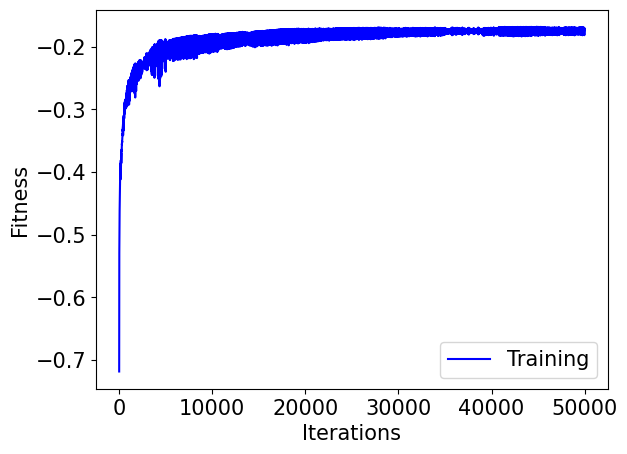

In [9]:
nn_gd = mlrose_hiive.NeuralNetwork(hidden_nodes = [4], activation = 'relu', \
                           algorithm = 'gradient_descent', max_iters = 50000, \
                           bias = True, is_classifier = True, learning_rate = 0.001, \
                           early_stopping = True, clip_max = 1e+10, max_attempts = 100, \
                           random_state = 1988, curve=True)

nn_gd.fit(X_train, y_train)
fitness_curve_gd = nn_gd.fitness_curve

# train
y_train_pred = nn_gd.predict(X_train)
auc_train_gd = roc_auc_score(y_train, nn_gd.predicted_probs)

# validation
y_vld_pred = nn_gd.predict(X_vld)
auc_vld_gd = roc_auc_score(y_vld, nn_gd.predicted_probs)

print(auc_train_gd)
print(auc_vld_gd)

fontsize = 15
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(range(len(fitness_curve_gd)), fitness_curve_gd, label='Training', color='b')
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('Iterations', fontsize=fontsize) 
ax.set_ylabel('Fitness', fontsize=fontsize)
ax.legend(fontsize=fontsize)
plt.show()
plt.close(fig)

df = pd.DataFrame(fitness_curve_gd)
df.to_csv("fitness_curve_gd.csv")


0.9749353634013214
0.9044943820224719


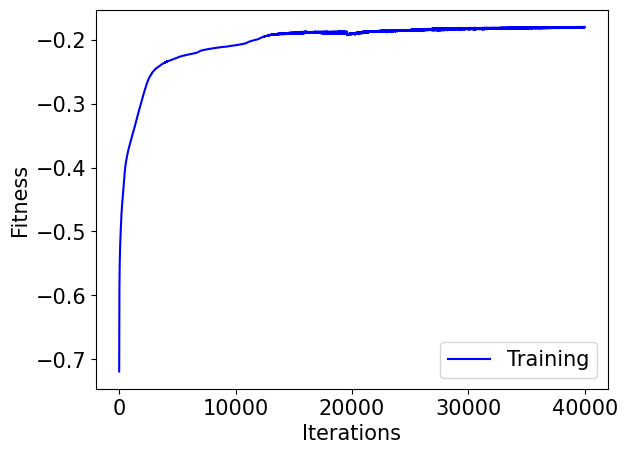

In [30]:
nn_gd = mlrose_hiive.NeuralNetwork(hidden_nodes = [4], activation = 'relu', \
                           algorithm = 'gradient_descent', max_iters = 40000, \
                           bias = True, is_classifier = True, learning_rate = 0.0002, \
                           early_stopping = True, clip_max = 1e+10, max_attempts = 100, \
                           random_state = 1988, curve=True)

nn_gd.fit(X_train, y_train)
fitness_curve_gd = nn_gd.fitness_curve

# train
y_train_pred = nn_gd.predict(X_train)
auc_train_gd = roc_auc_score(y_train, nn_gd.predicted_probs)

# validation
y_vld_pred = nn_gd.predict(X_vld)
auc_vld_gd = roc_auc_score(y_vld, nn_gd.predicted_probs)

print(auc_train_gd)
print(auc_vld_gd)

fontsize = 15
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(range(len(fitness_curve_gd)), fitness_curve_gd, label='Training', color='b')
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('Iterations', fontsize=fontsize) 
ax.set_ylabel('Fitness', fontsize=fontsize)
ax.legend(fontsize=fontsize)
plt.show()
plt.close(fig)

#df = pd.DataFrame(fitness_curve_gd)
#df.to_csv("fitness_curve_gd_0002.csv")


0.5056497175141244
0.5056179775280899


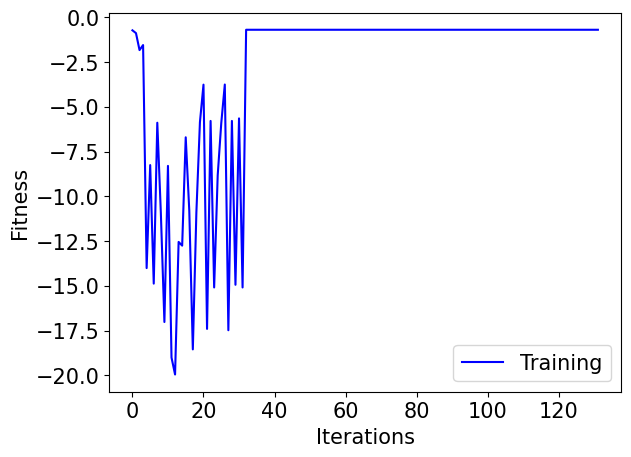

In [9]:
nn_gd = mlrose_hiive.NeuralNetwork(hidden_nodes = [4], activation = 'relu', \
                           algorithm = 'gradient_descent', max_iters = 50000, \
                           bias = True, is_classifier = True, learning_rate = 0.01, \
                           early_stopping = True, clip_max = 1e+10, max_attempts = 100, \
                           random_state = 1988, curve=True)

nn_gd.fit(X_train, y_train)
fitness_curve_gd = nn_gd.fitness_curve

# train
y_train_pred = nn_gd.predict(X_train)
auc_train_gd = roc_auc_score(y_train, nn_gd.predicted_probs)

# validation
y_vld_pred = nn_gd.predict(X_vld)
auc_vld_gd = roc_auc_score(y_vld, nn_gd.predicted_probs)

print(auc_train_gd)
print(auc_vld_gd)

fontsize = 15
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(range(len(fitness_curve_gd)), fitness_curve_gd, label='Training', color='b')
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('Iterations', fontsize=fontsize) 
ax.set_ylabel('Fitness', fontsize=fontsize)
ax.legend(fontsize=fontsize)
plt.show()
plt.close(fig)

df = pd.DataFrame(fitness_curve_gd)
df.to_csv("fitness_curve_gd_001.csv")

0.9713923202144977
0.9258426966292135


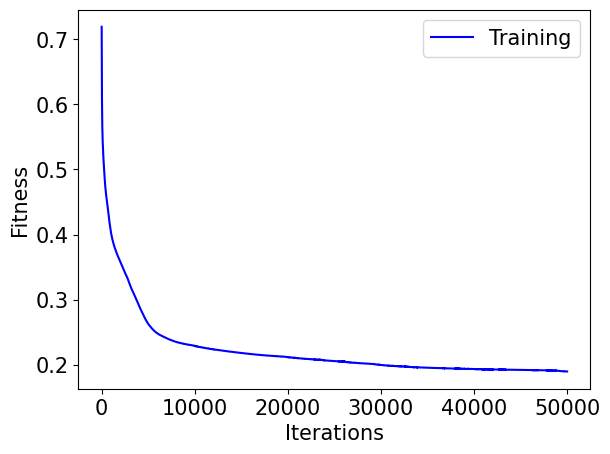

In [10]:
nn_gd = mlrose_hiive.NeuralNetwork(hidden_nodes = [4], activation = 'relu', \
                           algorithm = 'gradient_descent', max_iters = 50000, \
                           bias = True, is_classifier = True, learning_rate = 0.0001, \
                           early_stopping = True, clip_max = 1e+10, max_attempts = 100, \
                           random_state = 1988, curve=True)

nn_gd.fit(X_train, y_train)
fitness_curve_gd = nn_gd.fitness_curve

# train
y_train_pred = nn_gd.predict(X_train)
auc_train_gd = roc_auc_score(y_train, nn_gd.predicted_probs)

# validation
y_vld_pred = nn_gd.predict(X_vld)
auc_vld_gd = roc_auc_score(y_vld, nn_gd.predicted_probs)

print(auc_train_gd)
print(auc_vld_gd)

fontsize = 15
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(range(len(fitness_curve_gd)), -fitness_curve_gd, label='Training', color='b')
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('Iterations', fontsize=fontsize) 
ax.set_ylabel('Fitness', fontsize=fontsize)
ax.legend(fontsize=fontsize)
plt.show()
plt.close(fig)

df = pd.DataFrame(fitness_curve_gd)
df.to_csv("fitness_curve_gd_0001.csv")

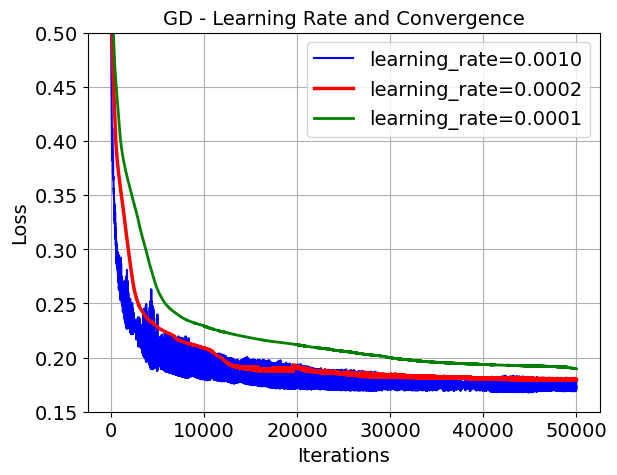

In [29]:
fitness_curve_lr1 = pd.read_csv('fitness_curve_gd.csv')
fitness_curve_lr2 = pd.read_csv("fitness_curve_gd_0002.csv")
fitness_curve_lr3 = pd.read_csv("fitness_curve_gd_0001.csv")


fontsize = 14
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(fitness_curve_lr1.values[:,0], -fitness_curve_lr1.values[:,1], label='learning_rate=0.0010', color='b')
ax.plot(fitness_curve_lr2.values[:,0], -fitness_curve_lr2.values[:,1], label='learning_rate=0.0002', color='r', linewidth=2.5)
ax.plot(fitness_curve_lr3.values[:,0], -fitness_curve_lr3.values[:,1], label='learning_rate=0.0001', color='g', linewidth=2)
ax.tick_params(labelsize=fontsize)
ax.set_xlabel('Iterations', fontsize=fontsize) 
ax.set_ylabel('Loss', fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.set_title('GD - Learning Rate and Convergence', fontsize=fontsize)
ax.set_ylim(0.15, 0.5)
plt.grid(True)
plt.show()
fig.savefig('gd_learning_rate.png')
plt.close(fig)

In [12]:
# Learning curve with respect to training set size
# Validation set remains the same

training_size_list = list(np.arange(0.05, 1.05, 0.05))

auc_train_lr2_gd = [0]*len(training_size_list)
auc_vld_lr2_gd = [0]*len(training_size_list)
acc_train_lr2_gd = [0]*len(training_size_list)
acc_vld_lr2_gd = [0]*len(training_size_list)
f1_train_lr2_gd = [0]*len(training_size_list)
f1_vld_lr2_gd = [0]*len(training_size_list)

i=-1

for training_size in training_size_list:
    
    i+=1
    
    nn_gd = mlrose_hiive.NeuralNetwork(hidden_nodes = [4], activation = 'relu', \
                           algorithm = 'gradient_descent', max_iters = 40000, \
                           bias = True, is_classifier = True, learning_rate = 0.0002, \
                           early_stopping = True, clip_max = 1e+10, max_attempts = 400, \
                           random_state = 1988)
                                       
    if training_size==1.0: 
        (X_train_red, y_train_red) = (X_train, y_train)
    else:
        # Shuffle data and then split into the training and the test set
        X_temp, X_train_red, y_temp, y_train_red = train_test_split(X_train, y_train, test_size = training_size,
                                                               shuffle = True, random_state = 1988, stratify = y_train)        
                                       
    nn_gd.fit(X_train_red, y_train_red)
                                       
    # train
    y_train_pred = nn_gd.predict(X_train_red)
    auc_train_lr2_gd[i] = roc_auc_score(y_train_red, nn_gd.predicted_probs)
    acc_train_lr2_gd[i] = accuracy_score(y_train_red, y_train_pred)
    f1_train_lr2_gd[i]  = accuracy_score(y_train_red, y_train_pred)
    
    # validation
    y_vld_pred = nn_gd.predict(X_vld)
    auc_vld_lr2_gd[i] = roc_auc_score(y_vld, nn_gd.predicted_probs)
    acc_vld_lr2_gd[i] = accuracy_score(y_vld, y_vld_pred)
    f1_vld_lr2_gd[i]  = accuracy_score(y_vld, y_vld_pred)   

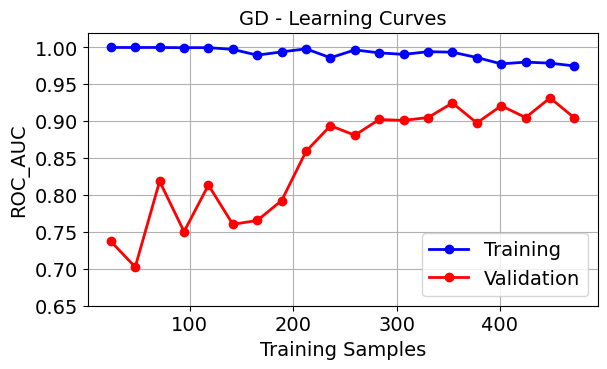

In [43]:
training_samples = np.array(training_size_list) * X_train.shape[0]

fontsize = 14
fig = plt.figure(figsize=(6,3.5))
ax = fig.add_axes([0.13, 0.15, 0.85, 0.78])
ax.plot(training_samples, auc_train_lr2_gd, '-o', label='Training', color='b',linewidth=2)
ax.plot(training_samples, auc_vld_lr2_gd, '-o', label='Validation', color='r',linewidth=2)
ax.set_xlabel('Training Samples', fontsize=fontsize)
ax.set_ylabel('ROC_AUC', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.legend(fontsize=fontsize)
ax.set_title('GD - Learning Curves', fontsize=fontsize)
plt.grid(True)
ax.set_ylim(0.65,1.02)
ax.set_yticks(np.arange(0.65,1.05,0.05))
plt.show()
fig.savefig('gd_learning_curves.png')
plt.close(fig)


In [14]:
# Final training
nn_gd = mlrose_hiive.NeuralNetwork(hidden_nodes = [4], activation = 'relu', \
                       algorithm = 'gradient_descent', max_iters = 40000, \
                       bias = True, is_classifier = True, learning_rate = 0.0002, \
                       early_stopping = True, clip_max = 1e+10, max_attempts = 100, \
                       random_state = 1988, curve=True)

tic = time.perf_counter()
nn_gd.fit(X_train_full, y_train_full)
toc = time.perf_counter()
train_time = toc-tic
print(f'Train time: {train_time}')
print(nn_gd.fitted_weights)
# train
y_train_full_pred = nn_gd.predict(X_train_full)
auc_train_full_gd = roc_auc_score(y_train_full, nn_gd.predicted_probs)
acc_train_full_gd = accuracy_score(y_train_full, y_train_full_pred)
# validation
y_test_pred = nn_gd.predict(X_test)
auc_test_gd = roc_auc_score(y_test, nn_gd.predicted_probs)
acc_test_gd = accuracy_score(y_test, y_test_pred)

print(f'auc_train_full_gd={auc_train_full_gd}, auc_test_gd={auc_test_gd}')
print(f'acc_train_full_gd={acc_train_full_gd}, acc_test_gd={acc_test_gd}')

Train time: 105.90352079994045
[-0.41170091 -0.53102032 -1.19037719 -0.73511339 -1.8443915  -0.23942359
 -0.26971042 -1.37844153  0.78677149 -1.33568937  0.18476952 -0.40451777
 -2.95508272 -0.37008458 -0.05256976 -1.8063573   3.2083553   0.37638257
  0.71512052  1.94537708  2.63057574  0.38827381  2.26757761  1.24760295
 -0.68172673  0.30793045  0.045014   -1.27315409 -2.51025947  1.04124605
  0.43022321 -0.40306121 -0.17717979 -0.84354379 -0.13519135 -0.81139362
  0.22106197  0.1099875   0.31238822 -0.59943111 -0.92093449  0.14628791
 -0.36465002 -0.39431025 -0.36270208  2.30522704  1.22641669  3.54679048
  1.66961935  0.42232156  1.05415059  1.22737451  1.36432674  0.06623962
  0.2571666   0.83818355  0.3666909  -0.17431185  0.36404865  0.28094151
 -0.53093546  0.25493186 -0.20967728 -0.26437362 -0.94205796  2.33882577
  2.24631576 -1.5641712   3.01937517 -3.49019156 -0.63076576  1.27317269
  2.26928008  0.45814078  1.71115568  1.51851841 -4.46785833 -4.42109411
  2.79672734  4.0312

In [15]:
np.savetxt('gd_final_fitness_curve.csv', nn_gd.fitness_curve, delimiter=',') 